The reconstruction from the *prorotype* samples in tha latent created by the Convolution-based autoencoder was not succcessfull. Even if the model is able to have recreate images in a descrete way from th etest set, the latent space is still to sparse and the result is that there are large pockets of white space between cluters. In these pockets, the model cannot be expected to produce any reasonable generation, as the data has not been mapped there.

This is because we have absolutely no regularization on our latent space, it is allowed to be whatever it needs to be to minimize our MSE Reconstruction Loss. If we are going to be sampling from a distribution, we have to pick which one we want, and the simplicity of normal distributions make them a natural choice. Therefore we will force our model to learn 
$P(x)$ by forcing the reconstruction loss AND making sure to map our latents to a nice Standard Normal distribution rather an unrestricted arbritrary one. If our latents are normally distributed, we know exactly the properties of it and our life becomes easier when we want to use it for some generative tasks.

<p align="center">
  <img src="https://www.researchgate.net/publication/346701232/figure/fig2/AS:969513902292992@1608161535014/Variational-Autoencoder-VAE-VAEs-40-are-used-to-learn-representations-of-the.png" alt="alt" width="700">
</p>

So we have set the goal. What we want is a model that can perform the reconstruction task like before, with the added restriction that the latent space must be close to a normal distribution. How Do We Force Latents To Be Gaussian?

There are two things we have to do:

- **Reconstruction Loss**: Make sure the output to the model looks like the input to the model, this is already done
- **KL Divergence Loss**: Measure the distance of our latent distribution from a Standard Normal and minimize it


### Kullback-Leibler (KL) Divergence

KL Divergence is a measure of entropy (or difference) between two probability distributions.
To understand it properly, we first need to understand entropy and cross-entropy.

Entropy measures how uncertain or unpredictable a probability distribution $P$ is. It is typically written as:

$$
H(P) = - \sum_{i=1}^{N} p(x_i) \cdot \log p(x_i)
$$

- A **low entropy** distribution means the outcomes are very predictable.
  Most of the probability mass is concentrated on a few outcomes, so observing
  the data is not very surprising.

- A **high entropy** distribution means the outcomes are very unpredictable.
  Probability mass is spread out, so each observation carries more surprise
  on average.

In [ ]:
import numpy as np

def entropy(p):
    """Compute entropy H(P) = -sum p log p"""
    p = np.array(p)
    p = p[p > 0]  # avoid log(0)
    return -np.sum(p * np.log(p))


# Low-entropy distribution (very predictable)
p_low = [0.97, 0.01, 0.01, 0.01] # [1.0 , 0.0] is a deterministic distribution

# High-entropy distribution (uniform, maximally uncertain)
p_high = [0.25, 0.25, 0.25, 0.25]

print("Low-entropy distribution:", p_low)
print("Entropy:", entropy(p_low))

print("\nHigh-entropy distribution:", p_high)
print("Entropy:", entropy(p_high))


Low-entropy distribution: [0.97, 0.01, 0.01, 0.01]
Entropy: 0.16770053683981007

High-entropy distribution: [0.25, 0.25, 0.25, 0.25]
Entropy: 1.3862943611198906


Entropy assumes that we use the *correct* distribution to measure surprise.
However, in practice, we often do not know the true distribution that generated
the data.

Now suppose the data is actually generated by a true distribution $P$, but we
describe, encode, or model the data using a different distribution $Q$.
In this case, the surprise of observing an outcome $x_i$ is not measured by
$-\log p(x_i)$ (which assumes perfect knowledge), but by $-\log q(x_i)$,
because $Q$ is the model we are using.

A **low cross-entropy** means that $Q$ assigns high probability to outcomes
that are likely under $P$, so the model matches the data well.

A **high cross-entropy** means that $Q$ assigns low probability to outcomes
that frequently occur under $P$, leading to large surprise and inefficient
encoding.

This expected surprise when data from $P$ is measured using $Q$ is called
the **cross-entropy** between $P$ and $Q$:

$$
H(P, Q) = - \sum_{i=1}^{N} p(x_i) \cdot \log q(x_i)
$$

Cross-entropy alone is **not** a pure measure of how different two distributions
are. This is because it mixes two effects:
1. The intrinsic uncertainty of the true distribution $P$
2. The mismatch between the model distribution $Q$ and the true distribution $P$

Even if the model is perfect ($Q = P$), the cross-entropy does not vanish:

$$
H(P, P) = H(P)
$$

This means cross-entropy can be large simply because the data distribution itself
has high entropy, not because the model is inaccurate. To isolate *only* the difference between distributions, we subtract the entropy of the true distribution. This leads to the definition of **KL Divergence**. [KL Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) (also called **relative entropy**) measures how much an approximating probability distribution $Q$ is different from a true probability distribution $P$. It is defined as the difference between cross-entropy and entropy:

$$
D_{KL}(P \parallel Q) = H(P, Q) - H(P)
$$

Intuitively KL divergence subtracts out the part that **cannot improve** and isolate the distance between real and modeled distribution. Substituting the definitions of entropy and cross-entropy gives:

$$
\begin{aligned}
D_{KL}(P \parallel Q)
&= - \sum_{i=1}^{N} p(x_i) \log q(x_i)
  + \sum_{i=1}^{N} p(x_i) \log p(x_i) \\
&= \sum_{i=1}^{N} p(x_i) \cdot (\log p(x_i) - \log q(x_i))
\end{aligned}
$$

$$
\tilde{\mathcal{L}}_{\theta, \phi}(x; \epsilon)
=
\underbrace{\log p_{\theta}(x \mid z)}_{\text{Negative reconstruction error}}
+
\underbrace{\log p_{\theta}(z) - \log q_{\phi}(z \mid x)}_{\text{Regularization terms}}
$$

Using the logarithm identity $\log a - \log b = \log \frac{a}{b}$, this can be written as:

$$
D_{KL}(P \parallel Q)
= \sum_{i=1}^{N} p(x_i) \cdot \log \frac{p(x_i)}{q(x_i)}
$$

KL Divergence is always non-negative and equals zero if and only if $P = Q$. Our goal is to minimize this value.


---


In Bayesian Statistics, we typically have this form:

$$
P(A \mid B) = \frac{P(B \mid A) P(A)}{P(B)}
$$

Each piece of this actually has a name!

- $P(A \mid B)$: **Posterior Probability**, the probability of A occurring knowing B had occurred
- $P(B \mid A)$: **Likelihood Function**, the probability of B occurring knowing A had occurred
- $P(A)$ : **Prior Probability**, some initial belief you had about A before any evidence from data is utilized
- $P(B)$ : **Marginal (Evidence) Probability**, summing across all possible A in the joint distribution $P(A, B)$

In our case, we will use $P(z \mid x)$  where $z$  is our latent (compressed) variables and $x$  is the data.
This means we can write our encoder as $P(z \mid x)$  which is just our posterior, and the decoder $P(x \mid z)$  which is our likelihood function.

Let’s update our notation a bit so it follows what you typically see online.

- $q_\theta(z_i \mid x)$: The distribution of our latent variables $z_i$ given $x$,
  approximated by a neural network with parameters $\theta$.

- $p(z_i \mid x)$: The simpler distribution we selected to approximate with
  (typically a standard multivariate normal).

Our goal can then be written as:

$$
\min_{\theta} \; D_{KL}\big(q_\theta(z_i \mid x) \,\|\, p(z_i \mid x)\big)
$$

which expands to:

$$
\sum_{i=1}^{N} q_\theta(z_i \mid x) \cdot
\log \frac{q_\theta(z_i \mid x)}{p(z_i \mid x)}
$$

We can then use the conditional probability rule and rewrite:

$$
p(z_i \mid x) = \frac{p(z_i, x)}{p(x)}
$$

So we then substitute into our KL Divergence:


$$
\sum_{i=1}^{N} q_\theta(z_i \mid x) \cdot
\log \frac{q_\theta(z_i \mid x)\, p(x)}{p(z_i, x)}
$$

Applying the logarithm rule $\log(ab) = \log a + \log b$ gives:

$$
\sum_{i=1}^{N} q_\theta(z_i \mid x) \cdot
\log \frac{q_\theta(z_i \mid x)}{p(z_i, x)}
\;+\;
\sum_{i=1}^{N} q_\theta(z_i \mid x) \cdot \log p(x)
$$

In the second sum, $\log p(x)$ is a constant and does not depend on $z$,
so we can factor it out:

$$
\sum_{i=1}^{N} q_\theta(z_i \mid x) \cdot
\log \frac{q_\theta(z_i \mid x)}{p(z_i, x)}
\;+\;
\log p(x) \cdot \sum_{i=1}^{N} q_\theta(z_i \mid x)
$$

The second summation is over a probability distribution across all possible
latent values $z_i$, which must sum to 1:

$$
\sum_{i=1}^{N} q_\theta(z_i \mid x) = 1
$$

We are therefore left with:

$$
D_{KL}\big(q_\theta(z_i \mid x)\,\|\,p(z_i \mid x)\big)
=
\sum_{i=1}^{N} q_\theta(z_i \mid x) \cdot
\log \frac{q_\theta(z_i \mid x)}{p(z_i, x)}
\;+\;
\log p(x)
$$

Finally, using the relationship between joint and conditional distributions,
we can write:

$$
p(z_i, x) = p(z_i \mid x)p(x) = p(x \mid z_i)p(z_i)
$$

In this case, we definitely prefer the second form
$p(x \mid z_i)p(z_i)$ as everything in there is computable.
There are no nasty integrals over the unknown latent space $z$.
The first form contains $p(x)$, which would again require an
intractable integral. So let’s substitute this in:

$$
D_{KL}\big(q_\theta(z_i \mid x)\,\|\,p(z_i \mid x)\big)
=
\left(
\sum_{i=1}^{N}
q_\theta(z_i \mid x)\cdot
\log \frac{q_\theta(z_i \mid x)}{p(x \mid z_i)p(z_i)}
\right)
+
\log p(x)
$$

Let’s rearrange the terms a bit:

$$
-
\left(
\sum_{i=1}^{N}
q_\theta(z_i \mid x)\cdot
\log \frac{q_\theta(z_i \mid x)}{p(x \mid z_i)p(z_i)}
\right)
=
\log p(x)
-
D_{KL}\big(q_\theta(z_i \mid x)\,\|\,p(z_i \mid x)\big)
$$

We can remove the negative sign on the left by flipping the fraction
inside the logarithm:

$$
\sum_{i=1}^{N}
q_\theta(z_i \mid x)\cdot
\log \frac{p(x \mid z_i)p(z_i)}{q_\theta(z_i \mid x)}
=
\log p(x)
-
D_{KL}\big(q_\theta(z_i \mid x)\,\|\,p(z_i \mid x)\big)
$$

A key property of KL divergence is that it is never less than zero:
$$
D_{KL}(\cdot \| \cdot) \ge 0
$$

For clarity, let us rewrite the equation as:
$$
A = B - C
$$

From this, we can conclude two important things:

- If we want to minimize $C$ (our placeholder for KL divergence),
  this is equivalent to maximizing $A$. Therefore, our optimization
  problem changes from

$$
\min_\theta
D_{KL}\big(q_\theta(z_i \mid x)\,\|\,p(z_i \mid x)\big)
$$

to

$$
\max_\theta
\sum_{i=1}^{N}
q_\theta(z_i \mid x)\cdot
\log \frac{p(x \mid z_i)p(z_i)}{q_\theta(z_i \mid x)}
$$

- Since $C \ge 0$ due to the properties of KL divergence,
  it follows that $A \le B$. This means the left-hand side is always
  a lower bound on $\log p(x)$.


Using these properties, let’s rewrite the expression:

$$
\sum_{i=1}^{N}
q_\theta(z_i \mid x)\cdot
\log \frac{p(x \mid z_i)p(z_i)}{q_\theta(z_i \mid x)}
\;\le\;
\log p(x)
$$

Let’s take a look at the two conditional probabilities we have:

- $q_\theta(z_i \mid x)$:
  Use a neural network parameterized by $\theta$ to predict the latent variable $z_i$.
  This is handled by the **encoder** and represents our **posterior distribution**.

- $p(x \mid z_i)$:
  This is the reverse process and corresponds to the **likelihood function**.
  It is learned jointly by our **decoder**, which we parameterize by $\phi$.

Therefore, our encoder is $q_\theta(z_i \mid x)$ and our decoder is
$p_\phi(x \mid z_i)$. Substituting this into the inequality gives:

$$
\sum_{i=1}^{N}
q_\theta(z_i \mid x)\cdot
\log \frac{p_\phi(x \mid z_i)p(z_i)}{q_\theta(z_i \mid x)}
\;\le\;
\log p(x)
$$

Our optimization goal is to maximize the left-hand side of this equation,
which is a lower bound on $\log p(x)$. For this reason, it is known as the
**Evidence Lower Bound (ELBO)** of the original data distribution.

As we maximize this objective, we are equivalently maximizing the likelihood
of the data distribution as well.

Therefore, our final optimization problem becomes:


$$
\min_{\theta}\;
\sum_{i=1}^{N}
p(x_i)\cdot
\log \frac{p(x_i)}{q_\theta(x_i)}
\;\;\Longrightarrow\;\;
\max_{\theta,\phi}\;
\sum_{i=1}^{N}
q_\theta(z_i \mid x)\cdot
\log \frac{p_\phi(x \mid z_i)p(z_i)}{q_\theta(z_i \mid x)}
$$

now it is expressed in function of the encoder and decoder which will be optimized using backprop.

---

### Imposing Standard Normal Distributions on our Latents
Remember, it is our decision what distribution we want to use for these latents, and typically we use Normal Distributions! Lets write everything as Univariate Normal Distributions for now to keep the notation shorter, but the derivation will expand to Multivariate gaussians pretty easily (left as exercise).

Quick review of Gaussians.

$$
f(x) = \frac{1}{\sigma \sqrt{2\pi}}
\; e^{-\frac{1}{2}\left(\frac{x - \mu}{\sigma}\right)^2}
$$


A Gaussian distribution is defined (parameterized) by $\mu$ and $\sigma$.
A 1D Gaussian has a single mean $\mu$ and a single standard deviation $\sigma$,
and we can generate single numbers from this distribution that are normally
distributed.

[link](https://en.wikipedia.org/wiki/File:Galton_box.webm)

<p align="center">
  <img src="https://www.shutterstock.com/shutterstock/videos/1110291311/thumb/6.jpg?ip=x480" alt="alt" width="500">
</p>

A Gaussian distribution with $\mu = 0$ and $\sigma = 1$ is known as
**Standard Normal distribution**.

The problem is that if we took data and compressed it down to a latent space
with a dimension of just a single number, we would likely not achieve very good
performance. Instead, we want to compress the data down to a *vector* of numbers.
This vector should be normally distributed and sampled from a **Standard Multivariate Gaussian distribution**.

A multivariate Gaussian distribution is defined by:

- A mean vector $\vec{\mu}_d$ that defines the center of the distribution in
  $d$-dimensional space
- A covariance matrix $\Sigma_{d \times d}$ that specifies the variance of each
  variable and the covariance between each pair of variables
- A sampled data vector $\vec{x}_d$

More specifically, these quantities are defined as:

$$
\vec{x}_d = [x_1, x_2, \ldots, x_d]
$$

$$
\vec{\mu}_d =
[\mu_1 = \text{mean}(x_1),\;
 \mu_2 = \text{mean}(x_2),\;
 \ldots,\;
 \mu_d = \text{mean}(x_d)]
$$

$$
\Sigma_{d \times d} =
\begin{bmatrix}
\text{var}(x_1) & \text{cov}(x_1, x_2) & \cdots & \text{cov}(x_1, x_d) \\
\text{cov}(x_2, x_1) & \text{var}(x_2) & \cdots & \vdots \\
\vdots & \vdots & \ddots & \vdots \\
\text{cov}(x_1, x_d) & \cdots & \cdots & \text{var}(x_d)
\end{bmatrix}
$$

To further simplify this, for a **Standard Normal Multivariate Gaussian** distribution, the mean vector and covariance matrix take a very simple form: $\vec{\mu}_d = \vec{0}$ and $\Sigma_{d \times d} = I$ where $I$ is the identity matrix.

Back to the derivation of the loss. 

Normal distributions are represented by a mean $\mu$ and variance $\sigma^2$.
Let us allow $q_\theta(z \mid x)$ to have mean $\mu_q$ and variance $\sigma_q^2$,
and allow $p(z)$ to have mean $\mu_p$ and variance $\sigma_p^2$.
Then we can write:

$$
q_\theta(z \mid x)
=
\frac{1}{\sigma_q \sqrt{2\pi}}
\; e^{
-\frac{1}{2}
\left(\frac{x - \mu_q}{\sigma_q}\right)^2
}
$$

$$
p(z)
=
\frac{1}{\sigma_p \sqrt{2\pi}}
\; e^{
-\frac{1}{2}
\left(\frac{x - \mu_p}{\sigma_p}\right)^2
}
$$

Let us now plug these expressions into the KL divergence formula and simplify:

$$
D_{KL}\big(q_\theta(z \mid x)\,\|\,p(z)\big)
=
\sum_{z}
q_\theta(z \mid x)\cdot
\log \frac{q_\theta(z \mid x)}{p(z)}
$$

Substituting the Gaussian densities gives:

$$
=
\sum_{z}
\frac{1}{\sigma_q \sqrt{2\pi}}
\; e^{
-\frac{1}{2}
\left(\frac{x - \mu_q}{\sigma_q}\right)^2
}
\cdot
\log
\frac{
\frac{1}{\sigma_q \sqrt{2\pi}}
\; e^{
-\frac{1}{2}
\left(\frac{x - \mu_q}{\sigma_q}\right)^2
}
}{
\frac{1}{\sigma_p \sqrt{2\pi}}
\; e^{
-\frac{1}{2}
\left(\frac{x - \mu_p}{\sigma_p}\right)^2
}
}
$$

Simplifying constants inside the logarithm:

$$
=
\sum_{z}
\frac{1}{\sigma_q \sqrt{2\pi}}
\; e^{
-\frac{1}{2}
\left(\frac{x - \mu_q}{\sigma_q}\right)^2
}
\cdot
\log
\frac{
\sigma_p
\; e^{
-\frac{1}{2}
\left(\frac{x - \mu_q}{\sigma_q}\right)^2
}
}{
\sigma_q
\; e^{
-\frac{1}{2}
\left(\frac{x - \mu_p}{\sigma_p}\right)^2
}
}
$$

Using logarithm identities, this becomes:

$$
=
\sum_{z}
\frac{1}{\sigma_q \sqrt{2\pi}}
\; e^{
-\frac{1}{2}
\left(\frac{x - \mu_q}{\sigma_q}\right)^2
}
\cdot
\left(
\log \frac{\sigma_p}{\sigma_q}
-
\frac{(x - \mu_q)^2}{2\sigma_q^2}
+
\frac{(x - \mu_p)^2}{2\sigma_p^2}
\right)
$$


The normal distribution for $q$ in front has a constant factor, so we can pull it out:

$$
=
\frac{1}{\sigma_q \sqrt{2\pi}}
\sum_{z}
e^{-\frac{1}{2}\left(\frac{x - \mu_q}{\sigma_q}\right)^2}
\left(
\log \frac{\sigma_p}{\sigma_q}
-
\frac{(x - \mu_q)^2}{2\sigma_q^2}
+
\frac{(x - \mu_p)^2}{2\sigma_p^2}
\right)
$$

What does this look like?

We are weighting the expression

$$
\left(
\log \frac{\sigma_p}{\sigma_q}
-
\frac{(x - \mu_q)^2}{2\sigma_q^2}
+
\frac{(x - \mu_p)^2}{2\sigma_p^2}
\right)
$$

by the Gaussian kernel for $q(x \mid z)$.
This is exactly the definition of an **expected value** under $q$.

Since this entire expression is the KL divergence and our goal is to *minimize*
the KL divergence, we can ignore the constant factor in front.
(Minimizing $A\,D_{KL}$ is equivalent to minimizing $D_{KL}$.)

Thus we can rewrite the expression as:

$$
=
\mathbb{E}_q
\left[
\log \frac{\sigma_p}{\sigma_q}
-
\frac{(x - \mu_q)^2}{2\sigma_q^2}
+
\frac{(x - \mu_p)^2}{2\sigma_p^2}
\right]
$$

Separating the expectation across terms:

$$
=
\log \frac{\sigma_p}{\sigma_q}
-
\frac{1}{2\sigma_q^2}\,
\mathbb{E}_q\!\left[(x - \mu_q)^2\right]
+
\frac{1}{2\sigma_p^2}\,
\mathbb{E}_q\!\left[(x - \mu_p)^2\right]
$$

Now the variance appears.
Recall that for a random variable $x$:

$$
\operatorname{Var}(x) = \sigma^2 = \mathbb{E}\!\left[(x - \mu)^2\right]
$$

(?) Since $x \sim q$, we can replace the expectation involving $\mu_q$:

$$
=
\log \frac{\sigma_p}{\sigma_q}
-
\frac{\sigma_q^2}{2\sigma_q^2}
+
\frac{1}{2\sigma_p^2}
\mathbb{E}_q\!\left[(x - \mu_p)^2\right]
$$

which simplifies to:

$$
=
\log \frac{\sigma_p}{\sigma_q}
-
\frac{1}{2}
+
\frac{1}{2\sigma_p^2}
\mathbb{E}_q\!\left[(x - \mu_p)^2\right]
$$

Now we need to handle the remaining term
$\mathbb{E}_q[(x - \mu_p)^2]$,
which can be expanded using a simple algebraic identity before further
simplification.

$$
\mathbb{E}_q (x - \mu_p)^2 \\
= \mathbb{E}_q \big((x - \mu_q) + (\mu_q - \mu_p)\big)^2 \\
= \mathbb{E}_q \Big(
(x - \mu_q)^2
+ 2(x - \mu_q)(\mu_q - \mu_p)
+ (\mu_q - \mu_p)^2
\Big) \\
= \mathbb{E}_q[(x - \mu_q)^2]
+ 2\,\mathbb{E}_q[(x - \mu_q)(\mu_q - \mu_p)]
+ \mathbb{E}_q[(\mu_q - \mu_p)^2]
$$

Again, we can replace our first expected value since it is the variance formula,
and the last expected value is just a constant involving $(\mu_q - \mu_p)$
(the expected value of a constant is just the constant; the only random variable
here is $x$):

$$
= \sigma_q^2
+ 2\,\mathbb{E}_q[(x - \mu_q)(\mu_q - \mu_p)]
+ (\mu_q - \mu_p)^2 \\
= \sigma_q^2
+ (\mu_q - \mu_p)^2
+ 2(\mu_q - \mu_p)\,\mathbb{E}_q[x - \mu_q]
$$

$$
= \sigma_q^2
+ (\mu_q - \mu_p)^2
+ 2(\mu_q - \mu_p)\big(\mathbb{E}_q[x] - \mathbb{E}_q[\mu_q]\big) \\
= \sigma_q^2
+ (\mu_q - \mu_p)^2
+ 2(\mu_q - \mu_p)(\mu_q - \mu_q) \\
= \sigma_q^2 + (\mu_q - \mu_p)^2
$$

Let’s plug this result back into our original equation.

$$
\log \frac{\sigma_p}{\sigma_q}
- \frac{1}{2}
+ \frac{1}{2\sigma_p^2}\,\mathbb{E}_q (x - \mu_p)^2
$$

$$
= \log \frac{\sigma_p}{\sigma_q}
- \frac{1}{2}
+ \frac{\sigma_q^2 + (\mu_q - \mu_p)^2}{2\sigma_p^2}
$$

Now recall that the distribution $p(z)$ we want to map to is a **Standard Normal**
distribution with $\mu_p = 0$ and $\sigma_p = 1$. Substituting these values gives:

$$
= \log \frac{1}{\sigma_q}
- \frac{1}{2}
+ \frac{\sigma_q^2 + \mu_q^2}{2}
$$

$$
= \frac{1}{2}\log \frac{1}{\sigma_q^2}
- \frac{1}{2}
+ \frac{\sigma_q^2 + \mu_q^2}{2}
$$

$$
= \frac{1}{2}
\left(
\log \frac{1}{\sigma_q^2}
- 1
+ \sigma_q^2
+ \mu_q^2
\right)
$$

Remember this equation from before for our Evidence Lower Bound?

$$
\sum_{z}
q_\theta(z \mid x)\cdot
\log \frac{p_\phi(x \mid z)p(z)}{q_\theta(z \mid x)}
\;\le\;
\log p(x)
$$

We can now take our ELBO and split it up to form a loss function that includes
both the **KL divergence** term and the **reconstruction loss**.

$$
\sum_{z}
q_\theta(z \mid x)\cdot
\log \frac{p_\phi(x \mid z)p(z)}{q_\theta(z \mid x)}
$$

$$
=
\sum_{z}
q_\theta(z \mid x)\cdot
\log \frac{p_\phi(x \mid z)p(z)}{q_\theta(z \mid x)}
$$

Splitting the logarithm:

$$
=
\sum_{z}
q_\theta(z \mid x)\cdot
\log \frac{p(z)}{q_\theta(z \mid x)}
+
\sum_{z}
q_\theta(z \mid x)\cdot
\log p_\phi(x \mid z)
$$

Rewriting the first term and recognizing expectations:

$$
=
-
\sum_{z}
q_\theta(z \mid x)\cdot
\log \frac{q_\theta(z \mid x)}{p(z)}
+
\mathbb{E}_q[\log p_\phi(x \mid z)]
$$

The first term is exactly a KL divergence, so we obtain:

$$
=
- D_{KL}\big(q_\theta(z \mid x)\,\|\,p(z)\big)
+
\mathbb{E}_q[\log p_\phi(x \mid z)]
$$

or, more compactly:

$$
= - D_{KL} + \text{Reconstruction}
$$

Therefore, the ELBO consists of **negative KL divergence** plus the **expected
log-likelihood**, which is our reconstruction term. Since we want to maximize
the ELBO, we now substitute the closed-form expression we derived earlier for
the KL divergence between $q(z \mid x)$ and a standard normal prior $p(z)$:

$$
=
- D_{KL}\big(q_\theta(z \mid x)\,\|\,p(z)\big)
+
\mathbb{E}_q[\log p_\phi(x \mid z)]
$$

$$
=
-
\frac{1}{2}
\left(
\log \frac{1}{\sigma_q^2}
- 1
+ \sigma_q^2
+ \mu_q^2
\right)
+
\mathbb{E}_q[\log p_\phi(x \mid z)]
$$

Simplifying the negative sign:

$$
=
\frac{1}{2}
\left(
\log \sigma_q^2
+ 1
- \sigma_q^2
- \mu_q^2
\right)
+
\mathbb{E}_q[\log p_\phi(x \mid z)]
$$

That is the final function that we want to maximize, so we can force the
Evidence Lower Bound (ELBO) to increase, and therefore cause $p(x)$ to also
increase. However, in deep learning we typically perform **gradient descent**
rather than ascent. Maximizing a function is therefore equivalent to minimizing
the negative of that function.

So our final loss for the model is:

$$
\min_{\theta, \phi}
\;-\frac{1}{2}
\left(
\log \sigma_q^2
+ 1
- \sigma_q^2
- \mu_q^2
\right)
-
\mathbb{E}_q[\log p_\phi(x \mid z)]
$$

And that’s it! (Almost)

We have derived the final form of our loss function. Here are the components we
need to compute it:

- $\sigma_q^2$:
  Use a neural network parameterized by $\theta$ to compute the **variance** of
  a sample.

- $\mu_q^2$:
  Use a neural network parameterized by $\theta$ to compute the **mean** of a
  sample.

- $\log p_\phi(x \mid z)$:
  The **reconstruction loss**.
  But there’s a problem — what is $z$?


The variable $z$ is our latent variable (of some chosen dimensionality) that is
**sampled** from our distribution. The model learns the parameters of a Gaussian
(mean and variance), and then $z$ is a **random sample** drawn from the normal
distribution defined by those predicted parameters.

**Problem:** sampling introduces a stochastic node and breaks the computational graph.

---

### Reparamaterization Trick

If you recall, backpropagation requires performing the chain rule through a
sequence of nested functions. One of the requirements for this to work is that
all the functions must be **deterministic**: given the same input, they must
produce the same output. If a function is not deterministic, then its derivative
cannot be computed.

So how do we handle this?

The latent variable $z$ is sampled from a Gaussian distribution whose parameters
are predicted by $q(z \mid x)$. If we directly and randomly sample $z$ from this
distribution, there is no way for backpropagation to make its way back to
previous nodes in the computational graph, as illustrated above.

Instead, we make use of a neat property of **Normal distributions** that allows
us to move the stochastic node out of the way.

Let us say:

$$
X \sim \mathcal{N}(\mu = A,\; \sigma^2 = B)
$$

Normal distributions have the following properties:

- **Mean shift**  
  $$
  X + K \sim \mathcal{N}(\mu = A + K,\; \sigma^2 = B)
  $$
  Adding a constant to a random variable shifts the mean of the distribution.

- **Variance scaling**  
  $$
  X \cdot K \sim \mathcal{N}(\mu = A,\; \sigma^2 = B \cdot K^2)
  $$  
  Multiplying by a constant scales the variance by the square of that constant.


This means that if we want to sample from an arbitrary normal distribution
$$
\mathcal{N}(\mu = A,\; \sigma^2 = B),
$$
we can instead sample from a **standard normal distribution**
$$
\mathcal{N}(\mu = 0,\; \sigma^2 = 1)
$$
and then shift and scale it appropriately.

Specifically:

$$
\mathcal{N}(\mu = A,\; \sigma^2 = B)
=
A + \sqrt{B} \cdot \mathcal{N}(0, 1)
$$

When we scale the distribution, if $B$ is the variance we want and we multiply
by $\sqrt{B}$, we are really just multiplying by $\sigma$, the **standard
deviation**, which is always the square root of the variance.

<p align="center">
  <img src="https://media.geeksforgeeks.org/wp-content/uploads/20251210162750705790/decoder_model.webp" alt="alt" width="600">
</p>

Both directly sampling or the reparamaterization trick will give identical results, but by doing reparameterization, we split off the random nodes of the Neural Network away from the rest so our model remains fully differentiable! Lets quickly see how this works in practice:



In [1]:
import torch

### Without Reparamaterization ###
input_tensor = torch.tensor([3.])
w1 = torch.tensor([2.], requires_grad=True)
w_mu = torch.tensor([8.], requires_grad=True)
w_sd = torch.tensor([9.], requires_grad=True)

w1_out = w1*input_tensor
mu = w_mu*w1_out
std = w_sd*w1_out

z = torch.normal(mean=mu, std=std)

z.backward()

print("Propogated Gradient without Reparam. Trick", w1.grad)

### With Reparamaterization ###
w1_out = w1*input_tensor
mu = w_mu*w1_out
std = w_sd*w1_out

z = mu + std*torch.randn(1)

z.backward()

print("Propogated Gradient with Reparam. Trick", w1.grad)

Propogated Gradient without Reparam. Trick tensor([0.])
Propogated Gradient with Reparam. Trick tensor([32.5925])


### Log-Variance in the Reparameterization Trick

This has nothing to do with theory, but rather **stability and general practice**.
As we showed before, our neural network predicts the mean $\mu$ and the variance
$\sigma^2$. However, for numerical stability, models typically predict the
**log variance** instead of the variance directly.

This choice is mostly practical, but it is widely used and convenient, so we
will follow it here. This means we need to keep a few small details in mind.


When applying the reparameterization trick, we need to multiply by the **standard
deviation**, which is the square root of the variance.

Since the network outputs $\log \sigma^2$, we compute $\sigma$ as:

$$
e^{0.5 \cdot \log(\sigma^2)}
=
e^{\log(\sqrt{\sigma^2})}
=
e^{\log \sigma}
=
\sigma
$$

This allows us to recover the correct scaling factor while keeping everything
numerically stable and differentiable.

Additionally, our loss function already contains log-variance terms, so using
$\log \sigma^2$ directly ends up being slightly more convenient overall.

---

### Recap

That was a lot of derivation! None of it is especially difficult, but it does
require stepping through carefully to understand the **purpose** and
**architecture** of the model.

The main takeaway is that our final loss function is:

$$
\min_{\theta, \phi}
\;
-\frac{1}{2}
\left(
\log \sigma_q^2
+ 1
- \sigma_q^2
- \mu_q^2
\right)
-
\mathbb{E}_q[\log p_\phi(x \mid z)]
$$

where:
- $\mu_q$ is the mean predicted by the encoder network,
- $\log \sigma_q^2$ is the log-variance predicted by the encoder,
- and the expectation term is the **reconstruction loss** produced by the decoder.

This completes the full VAE objective and sets the stage for an actual
implementation.


In [10]:
import torch
from vae import LinearVAE

model = LinearVAE([784, 1000, 500, 250, 30])

rand = torch.randn(4, 1, 28, 28).view(4, 1, 784).view(4, -1)   # (batch=1, features=784)

out, z, mu, logvar = model(rand)            # match your forward() return order
print(out.shape, z.shape, mu.shape, logvar.shape)


torch.Size([4, 784]) torch.Size([4, 30]) torch.Size([4, 30]) torch.Size([4, 30])


In [ ]:
def VAELoss(x, y, mean, log_var, recon_weight=1, kl_weight=1):

    # compute the MSE For Every Pixel [B, H*W]
    pixel_mse = ((x-y)**2)

    # sum  up pixel loss per image and average across batch
    recon_loss = pixel_mse.sum(axis=-1).mean()

    # compute KL per image and sum across flattened latent
    kl = (1 + log_var - mean**2 - torch.exp(log_var)) #.flatten(1)
    kl_per_image = - 0.5 * torch.sum(kl, dim=-1)

    # average KL across the batch ###
    kl_loss = torch.mean(kl_per_image)
    
    return recon_weight*recon_loss, kl_weight*kl_loss

In [1]:
import torch

import torch.optim as optim


from vae import LinearVAE, VAELoss
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

torch.manual_seed(0)
torch.cuda.manual_seed(0)


trm = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1)),
    ]
)

train_set = MNIST("data/mnist/", train=True, transform=trm, download=False)
test_set = MNIST("data/mnist/", train=False, transform=trm, download=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


init_dim = train_set.data.size(-1) * train_set.data.size(-2)
model = LinearVAE([init_dim, 1000, 500, 250, 30]).to(device)
model.train()

optimizer = optim.AdamW(model.parameters(), lr=1e-3)

batch_size = 64
recon_weight, kl_weight = 1, 0.5
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

train_loss, train_recon, train_kl = [], [], []
eval_loss, eval_recon, eval_kl = [], [], []
eval_step = train_set.data.size(0) // batch_size // 10
step = 0
latent = {}

for epoch in range(1):
    for im, _ in trainloader:
        im = im.to(device)
        out, z, mu, logvar = model(im)


        recon_loss, kl_loss = VAELoss(out, im, mu, logvar, recon_weight, kl_weight)
        loss = recon_loss + kl_loss
        train_loss.append(loss.item())
        train_recon.append(recon_loss.item())
        train_kl.append(kl_loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if step % eval_step == 0 or step + 1 == train_set.data.size(0):
            model.eval()
            zs, ys = [], []

            for im, y in testloader:
                im = im.to(device)

                with torch.no_grad():
                    out, z, mu, logvar = model(im)

                zs.append(z)
                ys.append(y)

                recon_loss, kl_loss = VAELoss(out, im, mu, logvar, recon_weight, kl_weight)
                loss = recon_loss + kl_loss
                eval_loss.append(loss.item())
                eval_recon.append(recon_loss.item())
                eval_kl.append(kl_loss.item())

            latent[step] = (torch.cat(zs).detach().cpu(), torch.cat(ys).detach().cpu())
            model.train()

            print(
                f"step {step}: "
                f"train total = {sum(train_loss)/len(train_loss):.4f} | "
                f"recon = {sum(train_recon)/len(train_recon):.4f} | "
                f"kl = {sum(train_kl)/len(train_kl):.4f} || "
                f"eval total = {sum(eval_loss)/len(eval_loss):.4f} | "
                f"recon = {sum(eval_recon)/len(eval_recon):.4f} | "
                f"kl = {sum(eval_kl)/len(eval_kl):.4f}"
            )

        step += 1

cuda
step 0: train total = 190.7207 | recon = 190.0726 | kl = 0.6482 || eval total = 176.1333 | recon = 176.1100 | kl = 0.0233
step 93: train total = 46.0339 | recon = 41.4821 | kl = 4.5518 || eval total = 106.1297 | recon = 102.7330 | kl = 3.3967
step 186: train total = 40.2388 | recon = 34.8263 | kl = 5.4125 || eval total = 81.3088 | recon = 76.8267 | kl = 4.4821
step 279: train total = 37.3988 | recon = 31.5666 | kl = 5.8322 || eval total = 68.6260 | recon = 63.5502 | kl = 5.0758
step 372: train total = 35.6059 | recon = 29.5196 | kl = 6.0863 || eval total = 60.5398 | recon = 55.0569 | kl = 5.4829
step 465: train total = 34.2948 | recon = 28.0081 | kl = 6.2868 || eval total = 55.1186 | recon = 49.3661 | kl = 5.7526
step 558: train total = 33.3488 | recon = 26.9031 | kl = 6.4457 || eval total = 51.0927 | recon = 45.1444 | kl = 5.9483
step 651: train total = 32.5669 | recon = 25.9927 | kl = 6.5742 || eval total = 47.9647 | recon = 41.7895 | kl = 6.1752
step 744: train total = 31.9187 

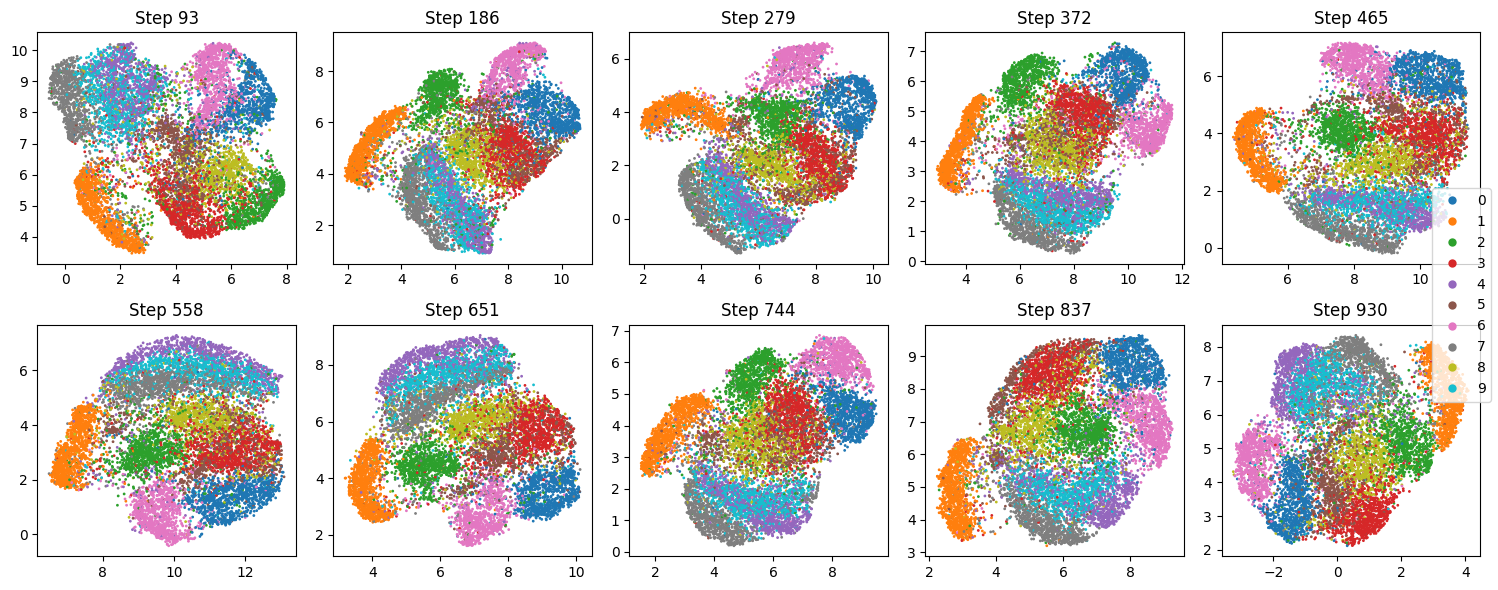

In [2]:
import umap
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

steps = list(latent.keys())[-10:]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for ax, step in zip(axes.flatten(), steps):
    z, y = latent[step]

    z2 = umap.UMAP(n_neighbors=15, min_dist=0.1).fit_transform(z)

    ax.scatter(
        z2[:, 0],
        z2[:, 1],
        c=y,
        s=1,
        cmap="tab10",
        vmin=0,
        vmax=9,
    )

    ax.set_title(f"Step {step}")

handles = [
    Line2D(
        [0],
        [0],
        marker="o",
        linestyle="",
        markerfacecolor=plt.cm.tab10(i),
        markeredgecolor="none",
        label=str(i),
    )
    for i in range(10)
]

fig.legend(handles=handles, loc="center right")

plt.tight_layout()
plt.show()

In [3]:
coord = torch.tensor([[-2, -2.4]], dtype=torch.float) # 

model.eval()
with torch.no_grad():
    pred = model.decode(coord.to(device)).cpu()

pred = pred.view(1, 1, 28, 28)

plt.imshow(pred[0, 0], cmap="gray")
plt.axis("off")
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 30x250)

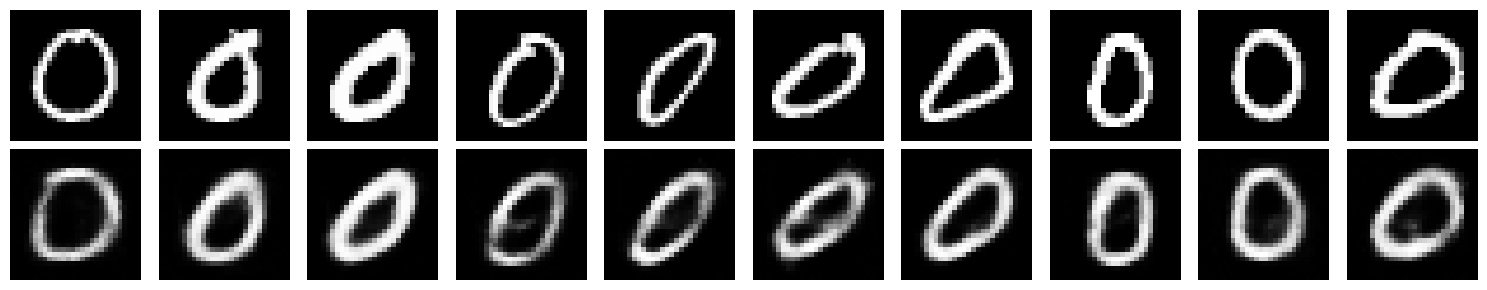

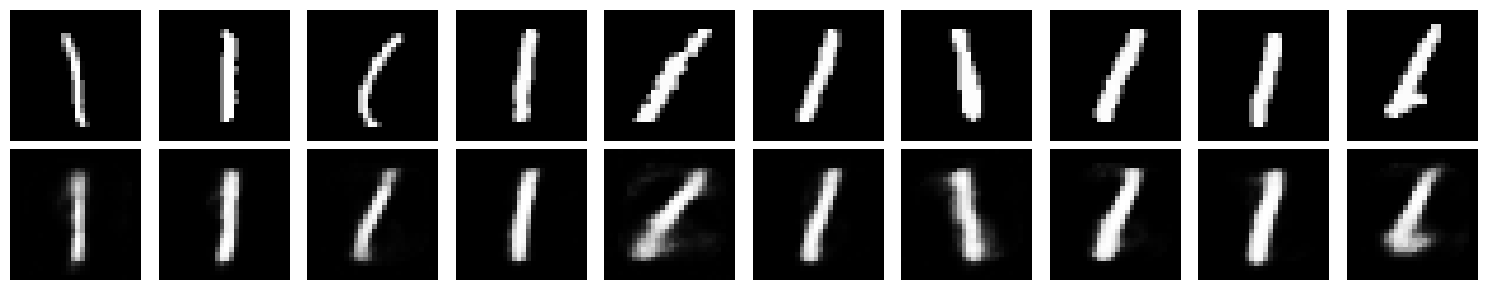

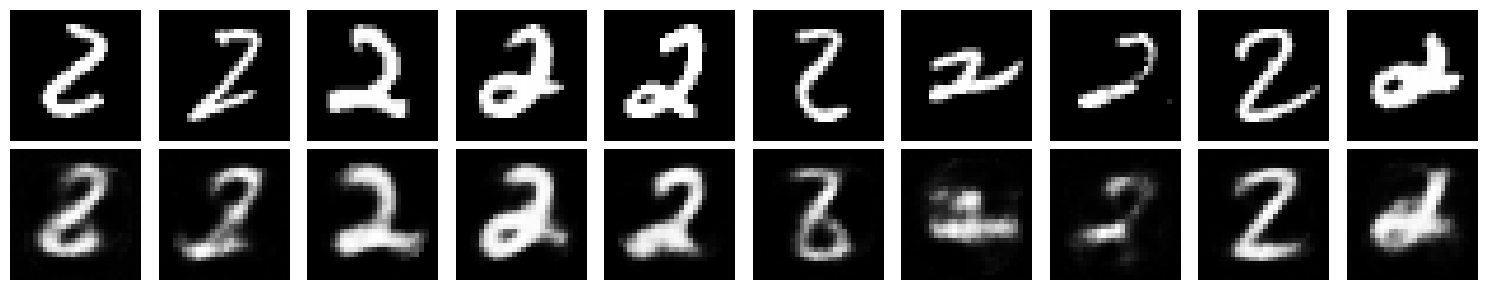

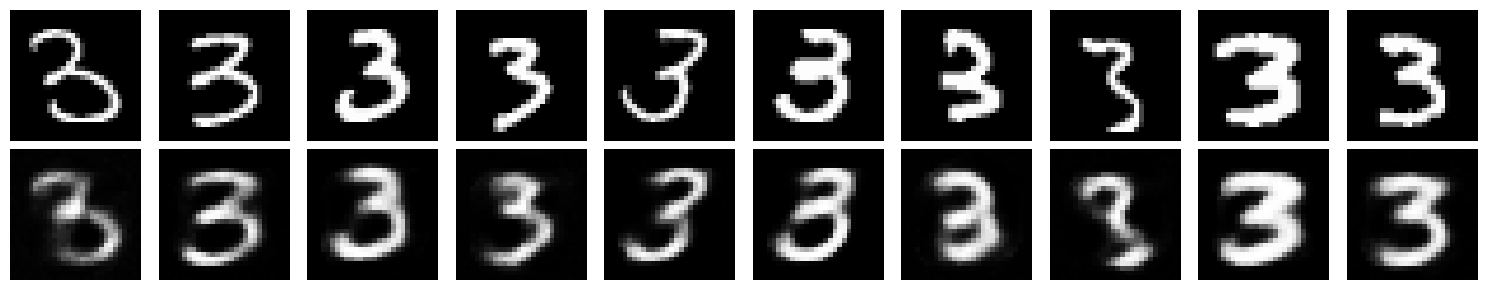

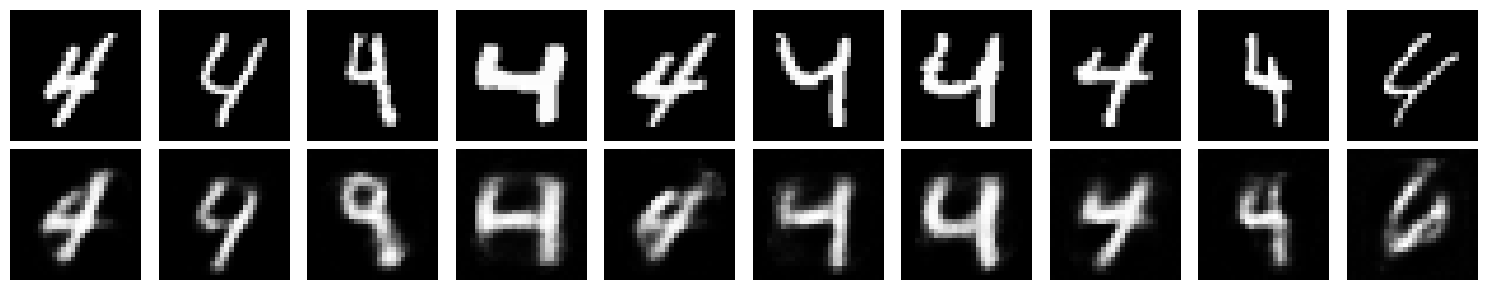

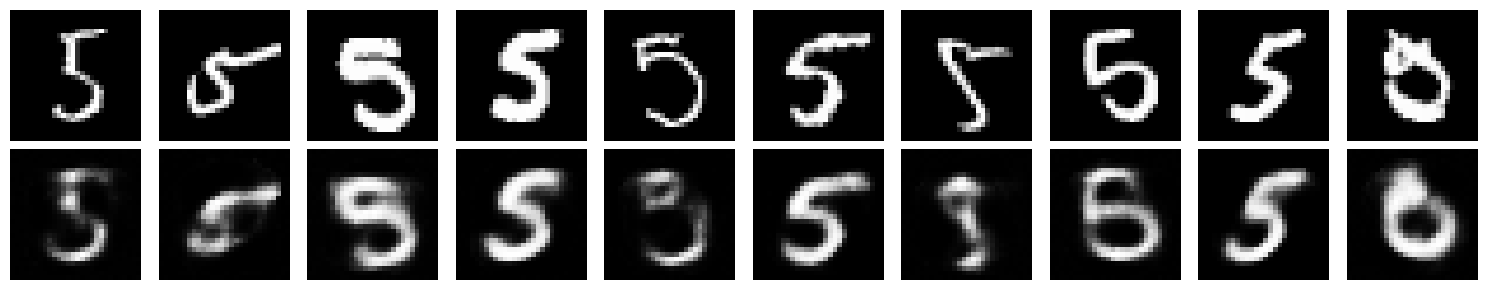

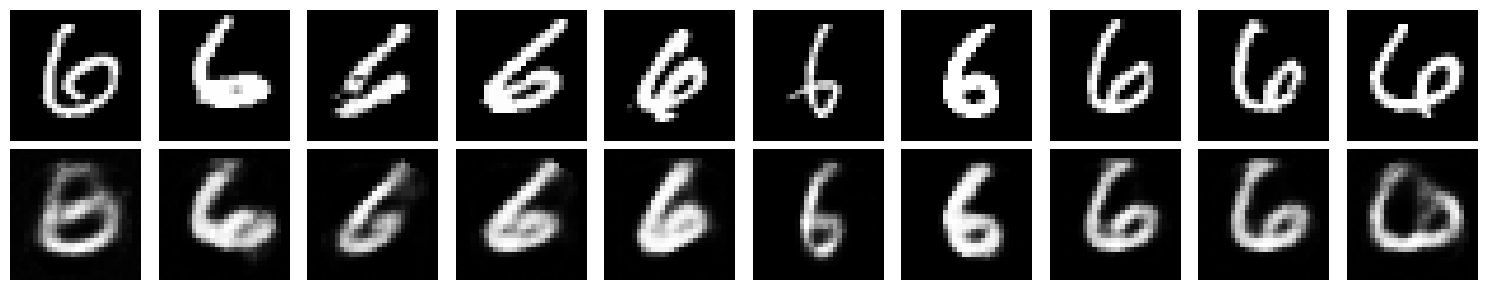

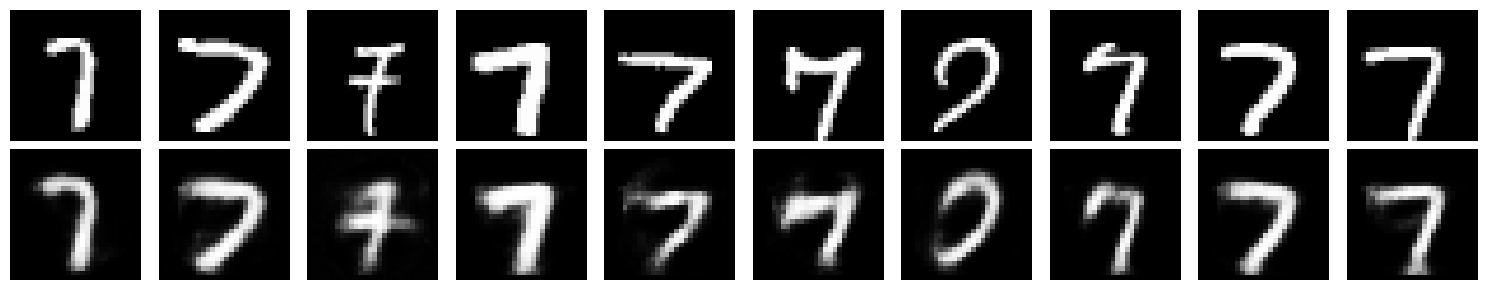

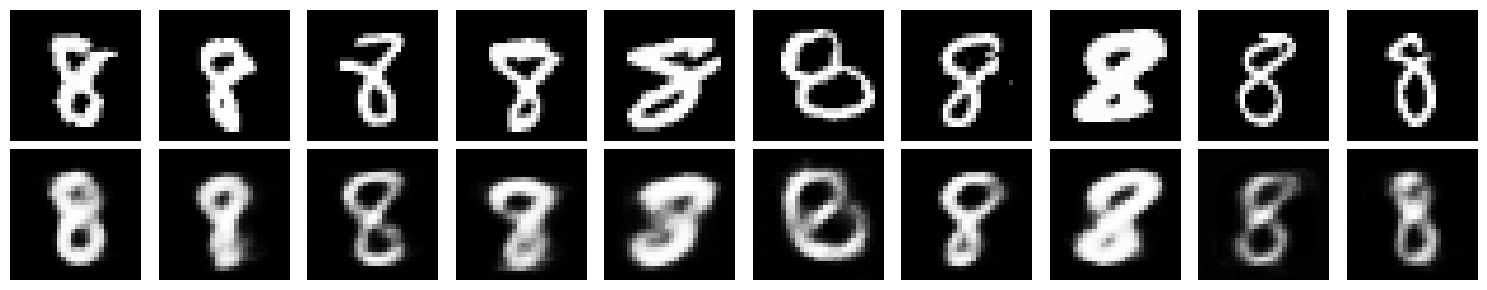

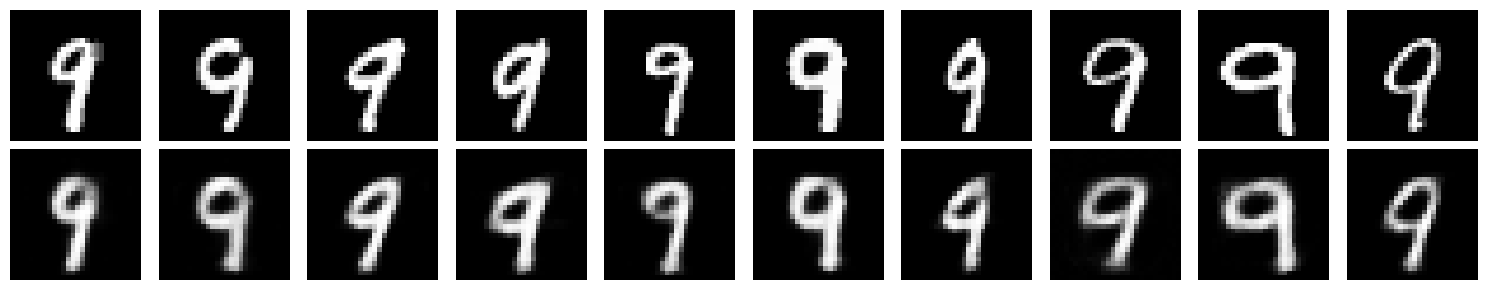

In [3]:
import random
import matplotlib.pyplot as plt

model.eval()

for digit in range(10):
    idxs = [i for i, (_, y) in enumerate(test_set) if y == digit]
    chosen = random.sample(idxs, 10)

    fig, axes = plt.subplots(2, 10, figsize=(15, 3))

    for col, idx in enumerate(chosen):
        image, label = test_set[idx]

        with torch.no_grad():
            rec, _, _, _ = model(image.unsqueeze(0).to(device))

        image = image.view(28, 28)  # or (32,32)
        rec = rec.cpu().view(28, 28)

        # input (top row)
        axes[0, col].imshow(image, cmap="gray")
        axes[0, col].axis("off")

        # reconstruction (bottom row)
        axes[1, col].imshow(rec, cmap="gray")
        axes[1, col].axis("off")

    plt.tight_layout()
    plt.show()

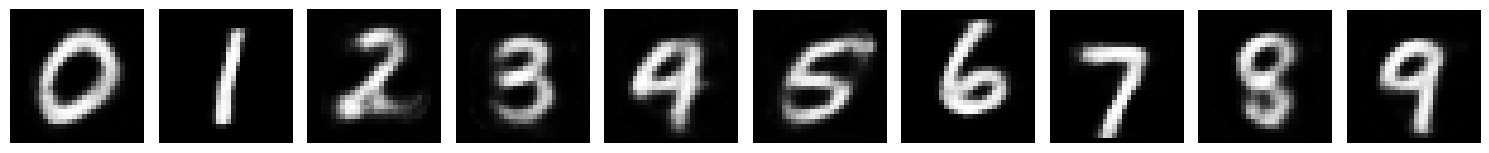

In [22]:
import torch
import matplotlib.pyplot as plt

last_step = list(latent.keys())[-1]
z, y = latent[last_step]
z = z.cpu()
y = y.cpu()

proto = []
for digit in range(10):
    z_d = z[y == digit]                          # [Nd, latent_dim]
    mu  = torch.median(z_d, dim=0).values        # center
    std = z_d.std(dim=0).clamp_min(1e-3)         # scale

    eps = torch.randn_like(mu)
    proto.append(mu + 0.5 * std * eps)           # <-- randomness

proto = torch.stack(proto, dim=0)                # [10, latent_dim]

model.eval()
with torch.no_grad():
    pred = model.decode(proto.to(device)).cpu()

pred = pred.view(10, 1, 28, 28)

fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for d in range(10):
    axes[d].imshow(pred[d, 0], cmap="gray")
    axes[d].axis("off")

plt.tight_layout()
plt.show()


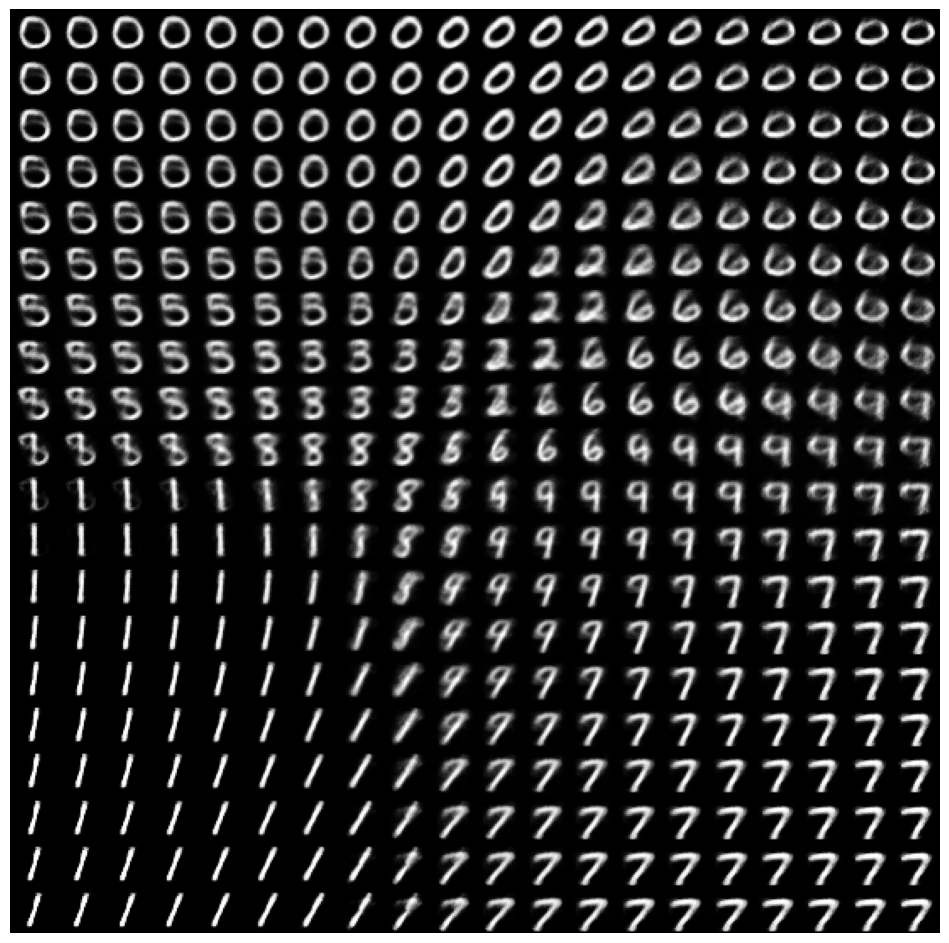

In [6]:
import matplotlib.pyplot as plt


def interpolate_space(model, x_range=(-3, 3), y_range=(-3, 3), num_steps=20,
                      img_shape=(1, 28, 28), device="cuda"):
    model.eval()

    # Build a num_steps x num_steps grid in latent space (no numpy)
    xs = torch.linspace(x_range[0], x_range[1], num_steps, device=device)
    ys = torch.linspace(y_range[0], y_range[1], num_steps, device=device)
    yy, xx = torch.meshgrid(ys, xs, indexing="ij")          # shapes: (num_steps, num_steps)
    points = torch.stack([xx, yy], dim=-1).reshape(-1, 2)   # shape: (num_steps^2, 2)

    with torch.no_grad():
        pred = model.decode(points)  # (num_steps^2, prod(img_shape))

    # Turn flat vectors into (C,H,W) images
    pred = pred.reshape(num_steps, num_steps, *img_shape).detach().cpu()

    fig, ax = plt.subplots(num_steps, num_steps, figsize=(12, 12))
    for i in range(num_steps):
        for j in range(num_steps):
            img = pred[i, j]
            if img.shape[0] == 1:
                ax[i, j].imshow(img[0], cmap="gray")
            else:
                ax[i, j].imshow(img.permute(1, 2, 0))  # still torch tensor
            ax[i, j].axis("off")

    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()

interpolate_space(model)